# Financial News - Preprocessing for word2vec

See notebook [lda_financial_news](../15_topic_modeling/07_financial_news/lda_financial_news.ipynb) for download instructions.

## Imports

In [1]:
import os, tarfile, sys
from pathlib import Path
from time import time
from pprint import pprint
from collections import Counter

import numpy as np
from numpy.random import choice
import pandas as pd
import seaborn as sns

import spacy
from spacy.lang.en import English

from gensim.models.word2vec import LineSentence
from gensim.models.phrases import Phrases, Phraser

### Settings

In [2]:
pd.set_option('float_format', '{:,.2f}'.format)
sns.set_style('whitegrid')
np.random.seed(42)

In [3]:
LANGUAGES = ['en', 'es']
language_dict = dict(zip(LANGUAGES, ['English', 'Spanish']))

In [4]:
def format_time(t):
    m, s = divmod(t, 60)
    h, m = divmod(m, 60)
    return '{:02.0f}:{:02.0f}:{:02.0f}'.format(h, m, s)

In [5]:
stop_words = set(pd.read_csv('http://ir.dcs.gla.ac.uk/resources/linguistic_utils/stop_words',
                             header=None,
                             squeeze=True).tolist())

In [72]:
data_path = Path('data', 'fin_news')
if not data_path.exists():
    data_path.mkdir(exist_ok=True)
article_path = data_path / 'articles.txt'
clean_article_path = data_path / 'articles_clean.txt'

## Load Data

In [22]:
fin_news_path = Path('..', '15_topic_modeling', '07_financial_news', 'us-financial-news-articles')

In [17]:
section_titles = ['Press Releases - CNBC', 'Reuters: Company News', 'Reuters: World News', 'Reuters: Business News',
                  'Reuters: Financial Services and Real Estate', 'Top News and Analysis (pro)', 'Reuters: Top News',
                  'The Wall Street Journal &amp; Breaking News, Business, Financial and Economic News, World News and Video',
                  'Business &amp; Financial News, U.S &amp; International Breaking News | Reuters',
                  'Reuters: Money News', 'Reuters: Technology News']

In [19]:
articles = []
counter = Counter()
start = time()
for f in fin_news_path.glob('*/**/*.json'):
    article = json.load(f.open())
    if article['thread']['section_title'] in set(section_titles):
        text = article['text'].lower().split()
        counter.update(text)
        articles.append(' '.join([t for t in text if t not in stop_words]))

print(f'Done loading {len(articles):,.0f} articles in {format_time(time()-start)}')

Done loading 125,964 articles in 00:00:44


In [21]:
article_path.write_text('\n'.join(articles))

418422851

## Clean Financial News Articles

In [7]:
articles = article_path.read_text().split('\n')
len(articles)

125964

### Sentence Boundary Detection

In [54]:
def clean_doc(d):
    doc = []
    for sent in d.sents:
        s = [t.text.lower() for t in sent if not
        any([t.is_digit, not t.is_alpha, t.is_punct, t.is_space])]
        if len(s) > 5 or len(sent) < 100:
            doc.append(' '.join(s))
    return doc

In [55]:
nlp = English()
sentencizer = nlp.create_pipe("sentencizer")
nlp.add_pipe(sentencizer)

In [56]:
clean_articles = []
iter_articles = (article for article in articles)
for i, doc in enumerate(nlp.pipe(iter_articles, batch_size=100, n_process=8), 1):
    if i % int(len(articles) / 100) + 1 == 0:
        print(f'{i / len(articles):.1%}', end=' ', flush=True)
    clean_articles.extend(clean_doc(doc))

In [57]:
clean_article_path.write_text('\n'.join(clean_articles))

294375807

### Corpus Stats

In [59]:
len(clean_articles)

2431127

In [60]:
vocab = Counter()
sent_length = []
for sentence in clean_articles:
    tokens = sentence.lower().split()
    sent_length.append(len(tokens))
    vocab.update(tokens)

In [61]:
len(sent_length)

2431127

In [62]:
pd.Series(sent_length).describe(percentiles=np.arange(.1, 1, .1).round(1))

count   2,431,127.00
mean           15.58
std             8.36
min             6.00
10%             7.00
20%             9.00
30%            10.00
40%            12.00
50%            14.00
60%            16.00
70%            18.00
80%            21.00
90%            25.00
max            90.00
dtype: float64

In [64]:
most_common = (pd.DataFrame(vocab.most_common(), columns=['token', 'count'])
               .pipe(lambda x: x[~x.token.str.lower().isin(stop_words)]))

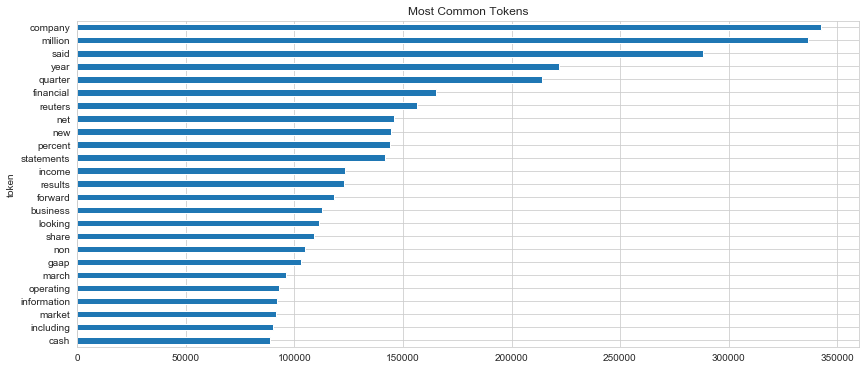

In [71]:
most_common.head(25).set_index('token')['count'].sort_values().plot.barh(title='Most Common Tokens', figsize=(14, 6));

### Inspect Result

In [63]:
clean_articles[:3]

['nyse ale today reported earnings share net income million operating revenue billion',
 'results share net income million operating revenue billion',
 'i pleased financial performance accomplishments continued execute multi faceted strategy growth returning million shareholders form dividends businesses positioned beyond said allete chairman president ceo al hodnik we believe unique mix businesses continue deliver strong value proposition shareholders supported recent announcement increase long term average annual earnings growth target percent percent percent previously increase dividend approximately percent']

## Create n-grams

In [74]:
max_length = 3

In [78]:
n_grams = pd.DataFrame()
start = time()
sentences = LineSentence(clean_article_path.as_posix())
for n in range(2, max_length + 1):
    print(n, end=' ')
    if n>2:
        sentences = LineSentence((data_path / f'articles_{n-1}_grams.txt').as_posix())
    phrases = Phrases(sentences, threshold=100, min_count=10)

    s = pd.Series({k.decode('utf-8'): v for k,
                   v in phrases.export_phrases(sentences)}) 
    s = s.to_frame('score').reset_index().rename(
        columns={'index': 'phrase'}).assign(length=n)

    n_grams = pd.concat([n_grams, s])
    grams = Phraser(phrases)
    sentences = grams[sentences]

    with (data_path / f'articles_{n}_grams.txt').open('w') as f:
        for sentence in sentences:
            f.write(' '.join(sentence) + '\n')

n_grams = n_grams.sort_values('score', ascending=False)
n_grams.phrase = n_grams.phrase.str.replace('_', ' ')
n_grams['ngram'] = n_grams.phrase.str.replace(' ', '_')

print('\n\tDuration: ', format_time(time() - start))
print(f'\tngrams: {len(n_grams)):,d}\n'
print(n_grams.groupby('length').size())

2 3 
	Duration:  00:07:50
	ngrams: 40,674

length
2    25039
3    15635
dtype: int64


In [84]:
n_grams.groupby('length').apply(lambda x: x.nlargest(10, 'score'))

phrase      score  length  \
length                                                                 
2      22681                mrinalini krothapalli 172,061.48       2   
       10393                pracha hariraksapitak 172,061.48       2   
       12632           mukhammadsharif mamatkulov 172,061.48       2   
       21718             hidradenitis suppurativa 172,061.48       2   
       22539                     navesh chitrakar 171,671.31       2   
       23357                         nidaa tounes 171,671.31       2   
       22699                       menara yayasan 171,671.31       2   
       12173                      koustav samanta 171,671.31       2   
       22792              munkhchimeg davaasharav 171,584.85       2   
       14018                  shilpa jamkhandikar 171,584.85       2   
3      10077                   castello di casole 178,605.83       3   
       5348              writing fransiska nangoy 178,605.83       3   
       6120                  dana reizniece ozola 178,605.83       3   
       12779  daniela palmieri jessica fitzgerald 178,605.83       3   
       7562        freshfields bruckhaus deringer 178,605.83       3   
       12552   strategist janney montgomery scott 178,605.83       3   
       11292          hgst sandisk tegile upthere 178,605.83       3   
       9917        carson elder beerman herberger 178,605.83       3   
       15416            afinitor afinitor disperz 178,200.82       3   
       4301               spokesman baik tae hyun 178,200.82       3   

                                            ngram  
length                                             
2      22681                mrinalini_krothapalli  
       10393                pracha_hariraksapitak  
       12632           mukhammadsharif_mamatkulov  
       21718             hidradenitis_suppurativa  
       22539                     navesh_chitrakar  
       23357                         nidaa_tounes  
       22699                       menara_yayasan  
       12173                      koustav_samanta  
       22792              munkhchimeg_davaasharav  
       14018                  shilpa_jamkhandikar  
3      10077                   castello_di_casole  
       5348              writing_fransiska_nangoy  
       6120                  dana_reizniece_ozola  
       12779  daniela_palmieri_jessica_fitzgerald  
       7562        freshfields_bruckhaus_deringer  
       12552   strategist_janney_montgomery_scott  
       11292          hgst_sandisk_tegile_upthere  
       9917        carson_elder_beerman_herberger  
       15416            afinitor_afinitor_disperz  
       4301               spokesman_baik_tae_hyun